In [1]:
import numpy as np
import glob
import cv2

import matplotlib.pyplot as plt

import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [2]:
train_tiff1 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image1/*')
train_tiff2 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image2/*')
train_label = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/label1/*')

train_tiff1.sort()
train_tiff2.sort()
train_label.sort()

In [3]:
test_tiff1 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛测试集/Image1/*')
test_tiff2 = glob.glob('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛测试集/Image2/*')

test_tiff1.sort()
test_tiff2.sort()

([], [])

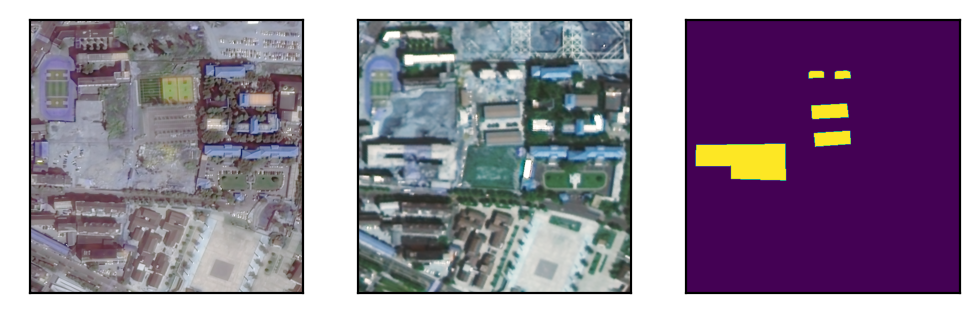

In [4]:
idx = 190
img1 = cv2.imread(train_tiff1[idx])
img2 = cv2.imread(train_tiff2[idx])
label = cv2.imread(train_label[idx])

plt.figure(dpi=200)
plt.subplot(131)
plt.imshow(img1)
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(img2)
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(label[:, :, 1] * 128)
plt.xticks([]); plt.yticks([])


In [5]:
train_tiff1[idx], train_tiff2[idx], train_label[idx]

('./高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image1/1223.tif',
 './高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/Image2/1223.tif',
 './高分辨率遥感影像建筑物变化检测挑战赛公开数据-初赛/初赛训练集/label1/1223.png')

In [57]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [58]:
DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, tiff1_path, tiff2_path, label_path, transform=None):
        self.tiff1_path = tiff1_path
        self.tiff2_path = tiff2_path
        self.label_path = label_path

        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        if self.tiff1_path[index] in DATA_CACHE:
            img1 = DATA_CACHE[self.tiff1_path[index]]
            img2 = DATA_CACHE[self.tiff2_path[index]]
            label = DATA_CACHE[self.label_path[index]]

        else:
            img1 = cv2.imread(self.tiff1_path[index])
            img2 = cv2.imread(self.tiff2_path[index])
            label = cv2.imread(self.label_path[index])
            # label = cv2.resize(label, (256, 256))
            
            DATA_CACHE[self.tiff1_path[index]] = img1
            DATA_CACHE[self.tiff2_path[index]] = img2
            DATA_CACHE[self.label_path[index]] = label
            
        if np.random.randint(10) > 5:
            img = np.dstack([img1, img2])
            img = img1 - img2
        else:
            img = np.dstack([img2, img1])
            img = img2 - img1

        if self.transform is not None:
            result = self.transform(image = img, mask=label)
            img = result['image']
            label = result['mask']
            
        img = img.transpose([2,0,1])
        label = label.transpose([2,0,1])
        return img, torch.from_numpy(label).long()
    
    def __len__(self):
        return len(self.tiff1_path)

In [61]:
import albumentations as A

train_dataset = XunFeiDataset(
    train_tiff1[:-500], train_tiff2[:-500], train_label[:-500],
    A.Compose([
    A.RandomRotate90(),
        # A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.RandomContrast(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225,))
]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

val_dataset = XunFeiDataset(
    train_tiff1[-500:], train_tiff2[-500:], train_label[-500:],
    A.Compose([
    A.RandomRotate90(),
        # A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.RandomContrast(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225,))
]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=False
)

In [62]:
model = model.to('cuda')
# criterion = nn.CrossEntropyLoss().cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), 0.001)

In [63]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output[:, 0, :, :], target[:, 0, :, :].float())

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0:
            print('Train loss', loss.item(), ((output[:, 0, :, :] > 0) * target[:, 0, :, :]).sum() / target[:, 0, :, :].sum())
            
        train_loss += loss.item()
    
    return train_loss/len(train_loader)
            
def validate(val_loader, model, criterion):
    model.eval()
    
    val_loss = 0.0
    val_iou = 0
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output[:, 0, :, :], target[:, 0, :, :].float())
            val_loss += loss.item()
            
            val_iou += ((output[:, 0, :, :] > 0) * target[:, 0, :, :]).sum() / target[:, 0, :, :].sum()
    
    output = output.data.cpu().numpy()
    target = target.data.cpu().numpy()
    
    plt.figure()
    plt.subplot(121)
    plt.imshow((output[0][0] > 0).astype(int) * 128)
    plt.xticks([]); plt.yticks([])

    plt.subplot(122)
    plt.imshow((target[0][0]).astype(int) * 128)
    plt.xticks([]); plt.yticks([])
    plt.show()
    
    return val_loss / len(val_loader), val_iou / len(val_loader)

In [64]:
class SoftDiceLossV1(nn.Module):
    '''
    soft-dice loss, useful in binary segmentation
    '''
    def __init__(self,
                 p=1,
                 smooth=1):
        super(SoftDiceLossV1, self).__init__()
        self.p = p
        self.smooth = smooth

    def forward(self, logits, labels):
        '''
        inputs:
            logits: tensor of shape (N, H, W, ...)
            label: tensor of shape(N, H, W, ...)
        output:
            loss: tensor of shape(1, )
        '''
        probs = torch.sigmoid(logits)
        numer = (probs * labels).sum()
        denor = (probs.pow(self.p) + labels.pow(self.p)).sum()
        loss = 1. - (2 * numer + self.smooth) / (denor + self.smooth)
        return loss

In [65]:
criterion = SoftDiceLossV1()

Train loss 0.8959429264068604 tensor(0.2747, device='cuda:0')
Train loss 0.9170630574226379 tensor(0.2946, device='cuda:0')
Train loss 0.9365643262863159 tensor(0.2597, device='cuda:0')
Train loss 0.974328875541687 tensor(0.2064, device='cuda:0')
Train loss 0.894428551197052 tensor(0.2861, device='cuda:0')
Train loss 0.9501595497131348 tensor(0.3915, device='cuda:0')
Train loss 0.9255945682525635 tensor(0.2842, device='cuda:0')
Train loss 0.8016585111618042 tensor(0.2868, device='cuda:0')
Train loss 0.849802553653717 tensor(0.3368, device='cuda:0')
Train loss 0.9480025768280029 tensor(0.4047, device='cuda:0')
Train loss 0.9320330023765564 tensor(0.3092, device='cuda:0')
Train loss 0.9608967304229736 tensor(0.3209, device='cuda:0')
Train loss 0.9324765205383301 tensor(0.2542, device='cuda:0')
Train loss 0.897470235824585 tensor(0.3167, device='cuda:0')
Train loss 0.9231611490249634 tensor(0.3486, device='cuda:0')
Train loss 0.9657196998596191 tensor(0.3064, device='cuda:0')
Train loss 0

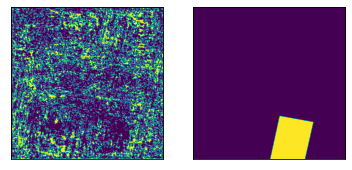

0.9210346025228501 0.9278258794546127 tensor(0.3047, device='cuda:0')
Train loss 0.9738619923591614 tensor(0.2492, device='cuda:0')
Train loss 0.9488113522529602 tensor(0.3223, device='cuda:0')
Train loss 0.9503963589668274 tensor(0.3085, device='cuda:0')
Train loss 0.9624634981155396 tensor(0.3443, device='cuda:0')
Train loss 0.9227750301361084 tensor(0.3001, device='cuda:0')
Train loss 0.8696916103363037 tensor(0.3003, device='cuda:0')
Train loss 0.9486939311027527 tensor(0.2914, device='cuda:0')
Train loss 0.9102185368537903 tensor(0.3031, device='cuda:0')
Train loss 0.956687331199646 tensor(0.2758, device='cuda:0')
Train loss 0.7459753751754761 tensor(0.3469, device='cuda:0')
Train loss 0.9641215205192566 tensor(0.3014, device='cuda:0')
Train loss 0.9572317004203796 tensor(0.2714, device='cuda:0')
Train loss 0.9638445377349854 tensor(0.4012, device='cuda:0')
Train loss 0.901911199092865 tensor(0.3720, device='cuda:0')
Train loss 0.9636207222938538 tensor(0.3338, device='cuda:0')
Tr

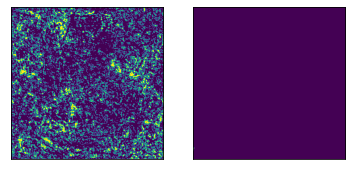

0.9195800217986106 0.9265653014183044 tensor(0.3392, device='cuda:0')
Train loss 0.8122459650039673 tensor(0.3127, device='cuda:0')
Train loss 0.9175748229026794 tensor(0.3900, device='cuda:0')
Train loss 0.9172376990318298 tensor(0.3447, device='cuda:0')
Train loss 0.853515625 tensor(0.4147, device='cuda:0')
Train loss 0.9287365078926086 tensor(0.2848, device='cuda:0')
Train loss 0.9635640382766724 tensor(0.3658, device='cuda:0')
Train loss 0.9809449911117554 tensor(0.3558, device='cuda:0')
Train loss 0.9245898723602295 tensor(0.3460, device='cuda:0')
Train loss 0.9586993455886841 tensor(0.3486, device='cuda:0')
Train loss 0.9640530347824097 tensor(0.3823, device='cuda:0')
Train loss 0.9502750635147095 tensor(0.4466, device='cuda:0')
Train loss 0.9473807215690613 tensor(0.4036, device='cuda:0')
Train loss 0.902904748916626 tensor(0.2765, device='cuda:0')
Train loss 0.9107259511947632 tensor(0.3647, device='cuda:0')
Train loss 0.8991224765777588 tensor(0.3632, device='cuda:0')
Train lo

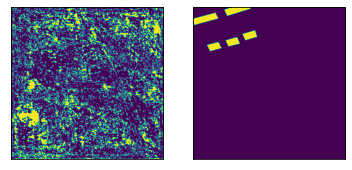

0.9180903469026088 0.9244923216104507 tensor(0.3940, device='cuda:0')
Train loss 0.895453155040741 tensor(0.2989, device='cuda:0')
Train loss 0.910843014717102 tensor(0.3740, device='cuda:0')
Train loss 0.9511454701423645 tensor(0.3825, device='cuda:0')
Train loss 0.9795176386833191 tensor(0.4117, device='cuda:0')
Train loss 0.96425861120224 tensor(0.2915, device='cuda:0')
Train loss 0.9338937401771545 tensor(0.3654, device='cuda:0')
Train loss 0.831699013710022 tensor(0.4015, device='cuda:0')
Train loss 0.9131311774253845 tensor(0.3421, device='cuda:0')
Train loss 0.892910361289978 tensor(0.3546, device='cuda:0')
Train loss 0.9295761585235596 tensor(0.3914, device='cuda:0')
Train loss 0.8786340355873108 tensor(0.3470, device='cuda:0')
Train loss 0.9098706245422363 tensor(0.3791, device='cuda:0')
Train loss 0.9701900482177734 tensor(0.4307, device='cuda:0')
Train loss 0.9328670501708984 tensor(0.3784, device='cuda:0')
Train loss 0.9296772480010986 tensor(0.4457, device='cuda:0')
Train 

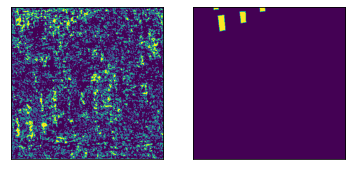

0.9157752262055874 0.9219502633810044 tensor(0.4242, device='cuda:0')
Train loss 0.9020574688911438 tensor(0.5033, device='cuda:0')
Train loss 0.9796569347381592 tensor(0.3463, device='cuda:0')
Train loss 0.808427095413208 tensor(0.3124, device='cuda:0')
Train loss 0.9548270106315613 tensor(0.4144, device='cuda:0')
Train loss 0.9325165748596191 tensor(0.4534, device='cuda:0')
Train loss 0.9589157104492188 tensor(0.4071, device='cuda:0')
Train loss 0.900563657283783 tensor(0.3001, device='cuda:0')
Train loss 0.9600783586502075 tensor(0.3878, device='cuda:0')
Train loss 0.9244883060455322 tensor(0.4563, device='cuda:0')
Train loss 0.8961891531944275 tensor(0.3833, device='cuda:0')
Train loss 0.9352254867553711 tensor(0.3328, device='cuda:0')
Train loss 0.9349505305290222 tensor(0.4274, device='cuda:0')
Train loss 0.9332599639892578 tensor(0.6398, device='cuda:0')
Train loss 0.8544531464576721 tensor(0.4703, device='cuda:0')
Train loss 0.9432092905044556 tensor(0.4840, device='cuda:0')
Tr

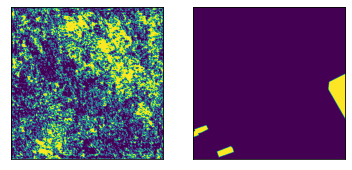

0.9130925746262073 0.9185256552696228 tensor(0.4861, device='cuda:0')
Train loss 0.9124773144721985 tensor(0.5152, device='cuda:0')
Train loss 0.9734179377555847 tensor(0.3757, device='cuda:0')
Train loss 0.874636173248291 tensor(0.4481, device='cuda:0')
Train loss 0.9171390533447266 tensor(0.5380, device='cuda:0')
Train loss 0.9311975836753845 tensor(0.5459, device='cuda:0')
Train loss 0.8881436586380005 tensor(0.4758, device='cuda:0')
Train loss 0.963473916053772 tensor(0.3973, device='cuda:0')
Train loss 0.9776936173439026 tensor(0.4089, device='cuda:0')
Train loss 0.9827980399131775 tensor(0.4746, device='cuda:0')
Train loss 0.7832421064376831 tensor(0.5359, device='cuda:0')
Train loss 0.9346864819526672 tensor(0.5004, device='cuda:0')
Train loss 0.9081504940986633 tensor(0.4758, device='cuda:0')
Train loss 0.8946285247802734 tensor(0.4838, device='cuda:0')
Train loss 0.973907470703125 tensor(0.6335, device='cuda:0')
Train loss 0.9262396097183228 tensor(0.4412, device='cuda:0')
Tra

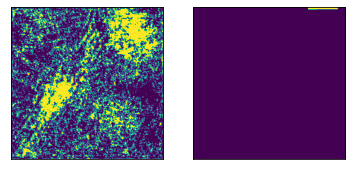

0.9085518987476826 0.9107856476306915 tensor(0.5826, device='cuda:0')
Train loss 0.9713150858879089 tensor(0.4910, device='cuda:0')
Train loss 0.9155741333961487 tensor(0.5034, device='cuda:0')
Train loss 0.7348238229751587 tensor(0.4474, device='cuda:0')
Train loss 0.8740834593772888 tensor(0.4160, device='cuda:0')
Train loss 0.9418244361877441 tensor(0.5917, device='cuda:0')
Train loss 0.9131982326507568 tensor(0.4767, device='cuda:0')
Train loss 0.9669943451881409 tensor(0.4545, device='cuda:0')
Train loss 0.8781597018241882 tensor(0.6157, device='cuda:0')
Train loss 0.778937816619873 tensor(0.5430, device='cuda:0')
Train loss 0.9327952265739441 tensor(0.6152, device='cuda:0')
Train loss 0.8175047636032104 tensor(0.5305, device='cuda:0')
Train loss 0.8654071688652039 tensor(0.7037, device='cuda:0')
Train loss 0.9400782585144043 tensor(0.5818, device='cuda:0')
Train loss 0.8188626170158386 tensor(0.5718, device='cuda:0')
Train loss 0.8653905987739563 tensor(0.4682, device='cuda:0')
T

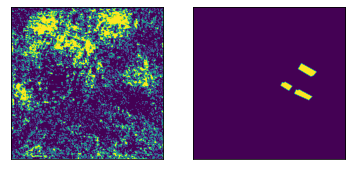

0.9032394930720329 0.9051148682832718 tensor(0.5650, device='cuda:0')
Train loss 0.9024145007133484 tensor(0.3412, device='cuda:0')
Train loss 0.8671789169311523 tensor(0.4373, device='cuda:0')
Train loss 0.9148522019386292 tensor(0.5598, device='cuda:0')
Train loss 0.9481798410415649 tensor(0.3620, device='cuda:0')
Train loss 0.9462800025939941 tensor(0.6035, device='cuda:0')
Train loss 0.9317156076431274 tensor(0.4940, device='cuda:0')
Train loss 0.8701121211051941 tensor(0.4486, device='cuda:0')
Train loss 0.8557261824607849 tensor(0.6960, device='cuda:0')
Train loss 0.8691507577896118 tensor(0.5996, device='cuda:0')
Train loss 0.9231264591217041 tensor(0.5468, device='cuda:0')
Train loss 0.9465665221214294 tensor(0.4639, device='cuda:0')
Train loss 0.8834704160690308 tensor(0.5758, device='cuda:0')
Train loss 0.8926267623901367 tensor(0.4407, device='cuda:0')
Train loss 0.9188036322593689 tensor(0.5336, device='cuda:0')
Train loss 0.920006275177002 tensor(0.5835, device='cuda:0')
T

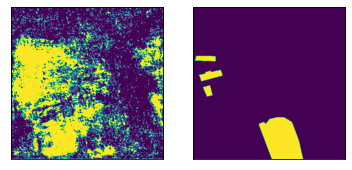

0.8965923525393009 0.8970388305187226 tensor(0.6311, device='cuda:0')
Train loss 0.9478033781051636 tensor(0.3520, device='cuda:0')
Train loss 0.9660776257514954 tensor(0.6199, device='cuda:0')
Train loss 0.9031081199645996 tensor(0.8524, device='cuda:0')
Train loss 0.937149703502655 tensor(0.6299, device='cuda:0')
Train loss 0.8464126586914062 tensor(0.5238, device='cuda:0')
Train loss 0.800430178642273 tensor(0.5196, device='cuda:0')
Train loss 0.9138761758804321 tensor(0.5854, device='cuda:0')
Train loss 0.9756174087524414 tensor(0.2905, device='cuda:0')
Train loss 0.825627863407135 tensor(0.4491, device='cuda:0')
Train loss 0.9232720732688904 tensor(0.6054, device='cuda:0')
Train loss 0.8216080665588379 tensor(0.6659, device='cuda:0')
Train loss 0.9303487539291382 tensor(0.4747, device='cuda:0')
Train loss 0.8672084808349609 tensor(0.5332, device='cuda:0')
Train loss 0.9190387725830078 tensor(0.6568, device='cuda:0')
Train loss 0.9663106203079224 tensor(0.4886, device='cuda:0')
Tra

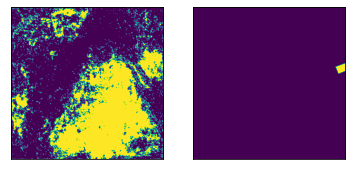

0.888642722517252 0.8886706221103668 tensor(0.6830, device='cuda:0')
Train loss 0.8719335198402405 tensor(0.5061, device='cuda:0')
Train loss 0.9515317678451538 tensor(0.5471, device='cuda:0')


KeyboardInterrupt: 

In [66]:
for _  in range(10):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_loss, val_iou = validate(val_loader, model, criterion)
    
    print(train_loss, val_loss, val_iou)

In [144]:
test_dataset = XunFeiDataset(
    test_tiff1[:], test_tiff1[:], test_tiff1[:],
    A.Compose([
    A.RandomRotate90(),
        # A.Resize(256, 256),
        # A.HorizontalFlip(p=0.5),
        # A.RandomContrast(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225, 0.229, 0.224, 0.225))
]))

test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=5, shuffle=False, num_workers=1, pin_memory=False
)

In [145]:
model.eval()
test_pred = []
with torch.no_grad():
    for i, (input, target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        output = output.data.cpu().numpy()
        
        output = (output[:, 0, :, :] > 0).astype(int)
        test_pred.append(output)

In [146]:
test_pred = np.vstack(test_pred)

In [148]:
import os
for path, pred in zip(test_tiff1, test_pred):
    cv2.imwrite(
        os.path.join('submit', os.path.basename(path).replace('tif', 'png')),
        pred.astype(np.uint8)
    )

In [147]:
!mkdir submit

In [149]:
!\rm submit.zip
!zip -r submit.zip submit

rm: 无法删除'submit.zip': 没有那个文件或目录
  adding: submit/ (stored 0%)
  adding: submit/3357.png (deflated 11%)
  adding: submit/1529.png (deflated 23%)
  adding: submit/1453.png (deflated 11%)
  adding: submit/2095.png (deflated 21%)
  adding: submit/2634.png (deflated 9%)
  adding: submit/2002.png (deflated 9%)
  adding: submit/345.png (deflated 7%)
  adding: submit/3109.png (deflated 8%)
  adding: submit/591.png (deflated 20%)
  adding: submit/2251.png (deflated 10%)
  adding: submit/1735.png (deflated 17%)
  adding: submit/1573.png (deflated 15%)
  adding: submit/2562.png (deflated 11%)
  adding: submit/1837.png (deflated 26%)
  adding: submit/92.png (deflated 16%)
  adding: submit/1101.png (deflated 9%)
  adding: submit/2637.png (deflated 35%)
  adding: submit/3113.png (deflated 10%)
  adding: submit/3130.png (deflated 7%)
  adding: submit/2454.png (deflated 12%)
  adding: submit/1600.png (deflated 22%)
  adding: submit/2822.png (deflated 32%)
  adding: submit/1449.png (deflated 9%)
  addi